## 学習用ノートブック

In [7]:
# ライブラリの読み込み
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import catboost as cb

In [8]:
# 前処理したデータを読み込む
train_p = pd.read_csv('../mid_output/train_preprocessed.csv')

In [9]:
# 使用する説明変数を指定
feature_cols =[
    'AgeInt', 'TypeofContactInt', 'CityTier', 'DurationInt', 'OccupationInt', "GenderInt", "NumberOfPersonVisiting", 
    "FollowupsNormalized", "ProductPitchedInt", "PreferredPropertyStar", "NumberOfTripsInt", "Passport", "PitchSatisfactionScore", 
    "DesignationInt", "MonthlyIncomeInt", "MaritalInt", "CarInt", "ChildInt"
]
# 目的変数を指定
target_col = 'ProdTaken'

In [10]:
# クロスバリデーションのためのデータを作成
N_SPLITS = 5
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
cv_list = list(skf.split(train_p[feature_cols], train_p[target_col]))

In [11]:
# catboostで学習させるための関数
def train_catboost(X, y, cv, params: dict = None):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records, ))
    for i, (tr_idx, va_idx) in enumerate(cv):
        tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
        tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]
        model = cb.CatBoostRegressor(**params)
        model.fit(tr_x, tr_y, eval_set=(va_x, va_y), use_best_model=True, verbose=100)
        oof_pred[va_idx] = model.predict(va_x)
        models.append(model)
    return oof_pred, models

In [12]:
# catboostで学習させる
params = {
    'loss_function': 'RMSE',
    'eval_metric': 'AUC',
    'iterations': 10000,
    'learning_rate': 0.005,
    'depth': 6,
    'verbose': 200,
    'random_seed': 42,
}

oof, models = train_catboost(train_p[feature_cols], train_p[target_col], cv_list, params)

0:	test: 0.7941260	best: 0.7941260 (0)	total: 48.4ms	remaining: 8m 3s
100:	test: 0.8306276	best: 0.8311356 (41)	total: 181ms	remaining: 17.7s
200:	test: 0.8322734	best: 0.8322937 (194)	total: 324ms	remaining: 15.8s
300:	test: 0.8337566	best: 0.8345694 (287)	total: 450ms	remaining: 14.5s
400:	test: 0.8346506	best: 0.8348741 (359)	total: 585ms	remaining: 14s
500:	test: 0.8354837	best: 0.8360323 (486)	total: 709ms	remaining: 13.4s
600:	test: 0.8356056	best: 0.8361339 (539)	total: 827ms	remaining: 12.9s
700:	test: 0.8346913	best: 0.8361339 (539)	total: 941ms	remaining: 12.5s
800:	test: 0.8346709	best: 0.8361339 (539)	total: 1.07s	remaining: 12.3s
900:	test: 0.8333706	best: 0.8361339 (539)	total: 1.19s	remaining: 12s
1000:	test: 0.8331471	best: 0.8361339 (539)	total: 1.3s	remaining: 11.7s
1100:	test: 0.8312169	best: 0.8361339 (539)	total: 1.43s	remaining: 11.5s
1200:	test: 0.8303432	best: 0.8361339 (539)	total: 1.55s	remaining: 11.3s
1300:	test: 0.8279659	best: 0.8361339 (539)	total: 1.67s	

In [16]:
# pickleでモデルを保存
import pickle

for i, model in enumerate(models):
    with open(f'../model/catboost_model_{i}.pkl', 'wb') as f:
        pickle.dump(model, f)

    feature_importance            column  fold
0             8.183908            AgeInt     1
1             2.400228  TypeofContactInt     1
2             6.690103          CityTier     1
3             2.035562       DurationInt     1
4             4.143749     OccupationInt     1
..                 ...               ...   ...
85           10.098420    DesignationInt     5
86           11.677904  MonthlyIncomeInt     5
87            7.749526        MaritalInt     5
88            2.167391            CarInt     5
89            2.851977          ChildInt     5

[90 rows x 3 columns]


/tmp/ipykernel_175101/977268783.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feature_importance_df,


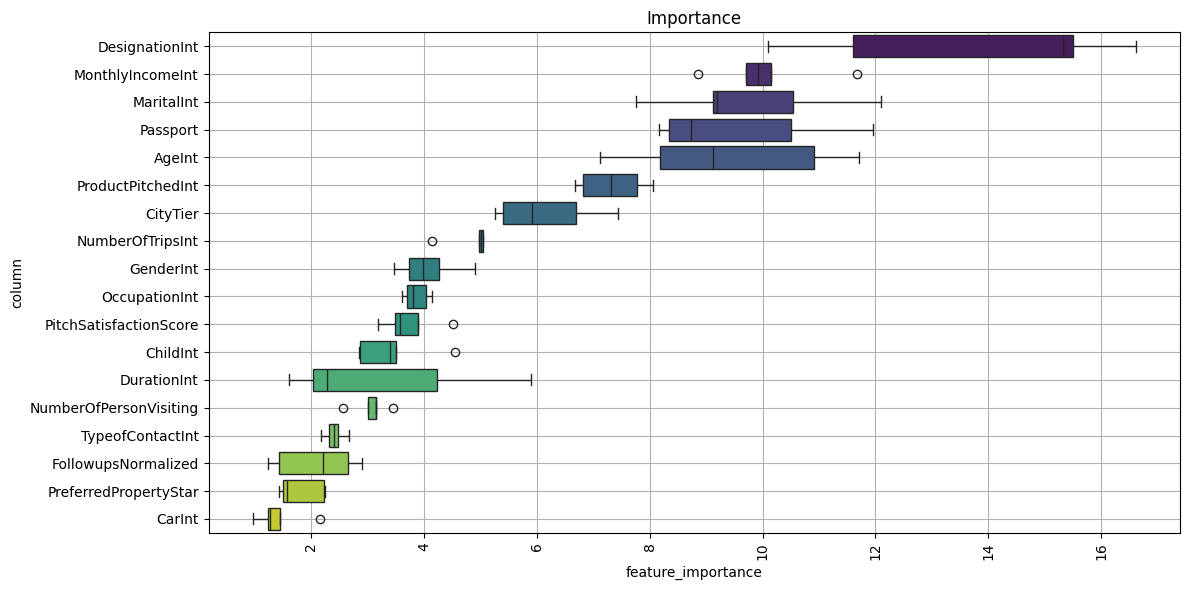

In [14]:
# ========================================
# feature importance
# ========================================
def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    print(feature_importance_df)
    #feature_importance_df_drop_speed = feature_importance_df[feature_importance_df["column"] != "speed"]
    sns.boxplot(data=feature_importance_df,
                  x="feature_importance",
                  y="column",
                  order=order,
                  ax=ax,
                  palette="viridis",
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax, feature_importance_df

fig, ax, feature_importance_df = visualize_importance(models, train_p[feature_cols])